**Chapter 18 – Reinforcement Learning**

**Jose Manuel Mora Balderas - 174707**

Los comentarios hechos en el codigo fueron realizados a partir de entender la documentacion proporcionada en el mismo codigo y consultas a ChatGPT

_This notebook contains all the sample code and solutions to the exercises in chapter 18._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [ ]:
#### Utilizaremos Python 3.7 o cualquier version mas reciente
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [ ]:
#### Mandamos a llamar TensorFlow
#### TensorFlow es una biblioteca de código abierto desarrollada por Google para realizar cálculos numéricos y ejecutar modelos de aprendizaje automático, especialmente redes neuronales.

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [ ]:
#### Definimos esto para poder proyectar graficos y mas recursos de cierta manera.

import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml') #### Utilizamos la opcion Javascript

And let's create the `images/rl` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
#### Se crea un folder en el mismo Collab para guardar imagenes

from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [ ]:
#### Se usa esto para en todo caso usar un GPU para que la ejecucion sea mas rapida, pero en mi caso no lo utilizare, por el momento todo ha corrido bien
#### y he entendido todo lo que se ha hecho

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes:**
* OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the [announcement](https://farama.org/Announcing-The-Farama-Foundation)), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install `gymnasium` instead of `gym`, and `import gymnasium as gym`, and everything should work fine.
* by running the following cell, you accept the Atari ROM license.

In [ ]:
#### Se nos menciona que, de hecho se hace mas adelante, que lo que se conocia como gym ahora es gymnasium y por eso luego se importa gymnasium y lo llamamos gym,
#### esto para que el codigo siga corriendo como antes
#### Aqui se instalan demas cosas de gymnasium como lo de Atari, Box2D y unas licencias

if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.1 MB/s eta 0:00:00


# Introduction to ~OpenAI gym~ Gymnasium

In this notebook we will be using [gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's import Gym and make a new CartPole environment:

In [ ]:
#### Al hacer clic en "gymnasium" nos lleva al GitHub donde en el README.md podemos ver documentacion e informacion sobre Gymnasium
#### Importaremos Gymnasium y haremos el CartPole environment
#### El CartPole (versión 1) es un entorno muy simple compuesto por un carrito que puede moverse hacia la izquierda o hacia la derecha, y un poste colocado verticalmente sobre él.
#### El agente debe mover el carrito hacia la izquierda o hacia la derecha para mantener el poste en posición vertical.

import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

#### gym.make() es una función de la biblioteca que se utiliza para crear una instancia de un entorno de aprendizaje por refuerzo específico.
#### El parámetro render_mode especifica cómo se va a renderizar el entorno en la pantalla.

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: `gym.envs.registry` is a dictionary containing all available environments:

In [ ]:
# extra code – shows the first few environments
#### Muestra los entornos de la biblioteca
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

The registry values are environment specifications:

In [ ]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

#### Nos muestra las especificaciones para el entorno

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [ ]:
obs, info = env.reset(seed=42)
obs

#### env.reset() restablece el estado del entorno al estado inicial y devuelve la observación inicial del agente, en este caso al poner seed=42, se establece la semilla aleatoria
#### del generador de números aleatorios del entorno en 42, por lo que siempre se inicializara de la misma manera cada vez que se llame a reset().
#### Después de ejecutar esta línea de código, obs contendrá la observación inicial del agente y info contendrá cualquier información adicional proporcionada por el entorno
#### (aunque generalmente no se utiliza). Ahora el entorno está listo para que el agente interactúe con él.

#### Cada observacion es un vector que tiene 4 floats, que representan:
#### la posicion horizontal del carrito, su velocidad, el angulo del poste y su velocidad angular
#### Estos elementos podemos verlos en la imagen proporcionada en las instrucciones de la asignacion

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [ ]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [ ]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

#### La forma de la matriz de la imagen es (400, 600, 3), lo que significa que la imagen tiene una altura de 400 píxeles,
#### una anchura de 600 píxeles y 3 canales de color, correspondientes a los componentes rojo, verde y azul (RGB) de la imagen.

(400, 600, 3)

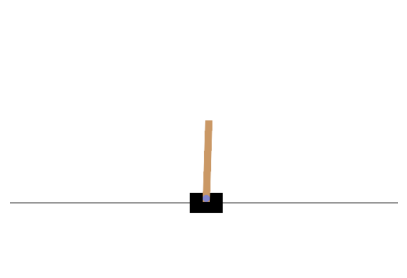

In [ ]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

#### Podemos ver como se ve nuestro carrito con su poste, el entorno

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [ ]:
env.action_space

#### env.action_space es un atributo que proporciona información sobre el espacio de acciones disponibles en el entorno.
#### El resultado Discrete(2) indica que el espacio de acciones en el entorno es discreto y consta de dos posibles acciones.
#### En el caso específico del entorno CartPole:
#### Una acción puede representar mover el carrito hacia la izquierda.
#### La otra acción puede representar mover el carrito hacia la derecha.

#### Codigo para ver el vector inicial y que significa cada cosa
#obs
#print("Cart's horizontal position, Cart's velocity, Angle of the pole, Angular Velocity.")

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [ ]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

#### Al ver que el poste se inclina hacia adelante, lo que queremos hacer es mover el carrito a la derecha
#### haciendo esto, el valor de nuestro vector cambiara, teniendo lo siguiente

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

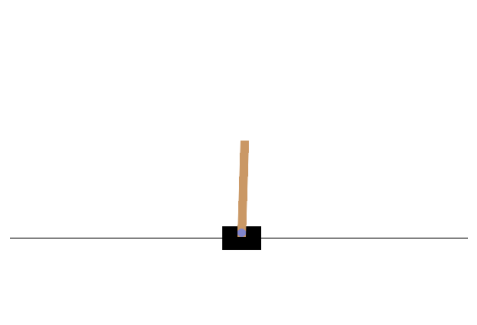

In [ ]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [ ]:
reward

#### La recompensa de nuestro entorno si hace bien las cosas

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [ ]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [ ]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [ ]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [ ]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [ ]:
#### Este enfoque de "A simple hard-coded policy" se refiere a una estrategia de toma de decisiones en la que las acciones del agente están predefinidas y no cambian en función
#### de la experiencia o del estado actual del entorno. En lugar de aprender una política óptima a través de la interacción con el entorno,
#### esta política está codificada manualmente por el programador, en este caso, en la siguiente funcion en la cual se le indica que si el poste esta inclinado a la izquierda,
#### entonces el carrito se mueve a la izquierda, y viceversa

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

#### La secuencia de pasos desde el momento en que se reinicia el entorno hasta que se completa o se trunca se llama "episode", e iteraremos en este caso 500.
totals = []
for episode in range(500):
    #### Se inicializa un contador total de "rewards"
    episode_rewards = 0
    obs, info = env.reset(seed=episode) #### Se inicializa el entorno en funcion del episodio en el que vaya el for
    for step in range(200): #### con 200 steps
        action = basic_policy(obs) #### basic_policy arroja un 0 que es ir a la izquierda (que es resultado de que el angulo sea negativo) o 1 que es ir a la derecha (que es resultado de que el angulo sea positivo)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward #### se actualiza el contador
        if done or truncated:
            break

    totals.append(episode_rewards)

In [ ]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

#### En el vector totals se mantuvo la informacion de los rewards en sus respectivos episodios
#### Como nos indican las siguientes estadisticas, en promedio de los 500 episodios se obtenia un promedio de 41 en rewards, que nos indica que en 41 steps se mantenia el poste parado
#### El minimo obtenido en un episodio fue de 24 (osea el peor), y el mejor caso fue de 63

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in the [Matplotlib tutorial notebook](tools_matplotlib.ipynb#Animations).

In [ ]:
# extra code – this cell displays an animation of one episode

#### Se anima un episodio de nuestro entorno

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    episode_rewards = 0
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward #### Puse esto para ver cuantos rewards se hacian, cada reward es 1, por lo que por 48 steps se mantuvo el poste derecho
        if done or truncated:     ####
           break                 #### Si comentamos esta linea y la de arriba, podemos ver la animacion entera de como el carrito se descontrola y el poste da vueltas como loco
    env.close()
    return plot_animation(frames)


show_one_episode(basic_policy)
#### print(episode_rewards) #en este caso fueron 48 steps


Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [ ]:
#### Se menciona arriba que ahora se trabajara con una politica de Redes Neuronales, donde para tomar cierta decision, se tomara en cuenta probabilidades
#### Como inputs tendremos las observaciones, y lo que seran los outputs seran las probabilidades de las acciones para hacer en cada observacion
#### La probabilidad p es de la accion de ir a la izquierda (0), y 1 - p la de ir a la derecha (1)

import tensorflow as tf

#### crea un modelo de red neuronal utilizando TensorFlow.

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([                         #### Esta línea crea un modelo secuencial utilizando la API de Keras, que es parte de TensorFlow. Un modelo secuencial es una pila lineal de capas. En este caso, se están definiendo las capas del modelo dentro de la lista
    tf.keras.layers.Dense(5, activation="relu"),      ####  Esta línea crea una capa densa con 5 neuronas y función de activación ReLU. Una capa densa es una capa completamente conectada en la que cada neurona está conectada a todas las neuronas de la capa anterior.
    tf.keras.layers.Dense(1, activation="sigmoid"),   #### Esta línea crea una capa densa con 1 neurona y función de activación sigmoide. La función de activación sigmoide es comúnmente utilizada en problemas de clasificación binaria para producir una salida en el rango [0, 1], que puede interpretarse como la probabilidad de pertenecer a una clase.
])

#### Lo que podemos concluir de esto es que se crea un modelo de red neuronal con dos capas: una capa oculta con 5 neuronas y activación ReLU,
#### y una capa de salida con 1 neurona y activación sigmoide.
#### Al ser este tipo de red neuronal utilizado para resolver problemas de clasificación binaria, podemos observar que es para saber si ir a la izquierda o la derecha

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

#### Lo que nos menciona esto es que el entorno puede trabajar solo con un estado porque toda la informacion necesaria esta contenida en el vector con todos los datos que tenemos

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

#### Se nos menciona sobre la importancia de encontrar un equilibrio entre Exploring y Exploiting, es importante este enfoque que se hace entre que aunque estemos trabajando con probabilidades y sonaria logico escoger la accion con mayor probabilidad, el hecho de escoger acciones aleatorias nos permite no quedarnos encerrados como en "maximos locales" donde no nos abramos a mas posibilidades que puedan ocurrir en el entorno

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [ ]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

Let's see if it can learn a better policy on its own. One that does not wobble as much.

#### El resultado que vimos fue muy malo, pero ahora veremos la capacidad de aprender sobre la politica que usamos anteriormente de ir a la izquierda si el poste se inclinaba a la izquierda y vicecersa, pero sera aprendida por su cuenta

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

#### Debemos de definir mejor que nos ayuda y que no nos ayuda, viendo mas como en que nos afecta en un futuro, y sabiendo identificar y definir correctamente que acciones en concreto fueron los que afectaron el resultado que obtuvimos, esto es lo que se define como "credit assignment problem"

#### El algoritmo de Policy Gradients simula episodios y por asi decirlo hace que las cosas que nos arrojan mas rewards positivos sucedan mas, y las que no son asi sucedan menos.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [ ]:
#### Se crea la funcion en un step
#### Esto para que al simularlo, podemos registrar su informacion y modificarlas despues dependiendo del desenlace que se obtuvo a raiz de dicha accion de la simulacion

def play_one_step(env, obs, model, loss_fn):  ####  Esto define una función llamada play_one_step que toma como argumentos el entorno (env), la observación actual (obs), el modelo neuronal (model), y la función de pérdida (loss_fn).
    with tf.GradientTape() as tape:           ####  Esto crea un contexto de cinta de gradientes, que permite registrar operaciones y calcular gradientes para todas las operaciones realizadas dentro de este bloque.
        left_proba = model(obs[np.newaxis])   ####  Esto pasa la observación actual al modelo neuronal y obtiene la probabilidad de que la acción izquierda sea seleccionada. La observación se convierte en un tensor de forma (1, N), donde N es la dimensión de la observación, para que sea compatible con el modelo.
        action = (tf.random.uniform([1, 1]) > left_proba)             #### Esto genera una acción basada en la probabilidad calculada por el modelo. Se elige una acción aleatoria utilizando una distribución uniforme y se compara con la probabilidad de que la acción izquierda sea seleccionada. La acción resultante se almacena en la variable action.
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)  #### Esto crea el objetivo de entrenamiento (y_target) para el modelo. Si la acción seleccionada es 1 (es decir, la acción derecha), el objetivo es 0; de lo contrario, es 1. Esto se hace para que el modelo aprenda a maximizar la recompensa.
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))          #### Esto calcula la pérdida entre el objetivo y la salida del modelo. La pérdida se reduce a través de una función de pérdida (loss_fn), que generalmente es la entropía cruzada en problemas de clasificación binaria.

    grads = tape.gradient(loss, model.trainable_variables)            #### Esto calcula los gradientes de la pérdida con respecto a los parámetros entrenables del modelo utilizando la cinta de gradientes.
    obs, reward, done, truncated, info = env.step(int(action))        #### Esto ejecuta la acción seleccionada en el entorno y obtiene la nueva observación, la recompensa resultante, y otros detalles del entorno.
    return obs, reward, done, truncated, grads                        #### Se devuelven

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [ ]:
#### Como hicimos el supuesto de que hicimos la decision correcta, ahora haremos mas decisiones basadas en la funcion anterior, recopilando los rewards y gradientes de cada episodio en cada step
#### La funcion consta de muchos vectores que guardan los resultados, ya sean los rewards, los gradientes, etc

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

#### Esta funcion calcula los rewards descontados retroactivamente, comenzando desde el último paso del episodio.
#### Aplica un factor de descuento a cada reward, donde los rewards más lejanos en el tiempo tienen un descuento mayor.
#### Devuelve una lista de rewards descontados.

#### El propósito de descontar los rewards es hacer que las acciones que conducen a recompensas a largo plazo sean más valoradas en el cálculo del gradiente.
#### Esto se debe a que los rewards futuros se descuentan, lo que significa que las acciones que producen recompensas futuras más altas se verán reforzadas en el aprendizaje.
#### El descuento también ayuda a estabilizar el entrenamiento al reducir la varianza de los rewards a lo largo del tiempo.

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]


#### Esta funcion utiliza la función discount_rewards para calcular los rewards descontados para cada episodio en la lista de episodios all_rewards.
#### Aplana todos los rewards descontados en una sola matriz y calcula su media y desviación estándar.
#### Normaliza los rewards descontados restando la media y dividiendo por la desviación estándar.
#### Devuelve una lista de listas con los rewards descontados y normalizados para cada episodio, lo que facilita su uso en el algoritmo de Policy Gradients.

#### Normalizar los rewards descontados es importante para estabilizar el entrenamiento del modelo.
#### Esto significa que los rewards descontados se ajustan para tener una media de cero y una desviación estándar de uno.
#### Normalizar los rewards ayuda a controlar el tamaño de los gradientes durante el entrenamiento.
#### Si los rewards no se normalizan, los gradientes pueden volverse demasiado grandes o demasiado pequeños, lo que dificulta la convergencia del modelo.

#### En resumen, estas funciones preparan los rewards para su uso en el algoritmo de Policy Gradients al descontarlos y normalizarlos,
#### lo que ayuda a mejorar la estabilidad y el rendimiento del entrenamiento de la red neuronal en problemas de aprendizaje por refuerzo.

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [ ]:
discount_rewards([10, 0, -50], discount_factor=0.8)

#### El descuento de recompensas es una técnica crucial en el aprendizaje por refuerzo porque:
#### Al descontar las recompensas futuras, el agente aprende a valorar las acciones que conducen a recompensas a largo plazo en lugar de solo recompensas inmediatas.
#### Estabiliza el proceso de aprendizaje reduciendo la varianza en los gradientes durante el entrenamiento.
#### Aplicar un factor de descuento permite que el agente tenga en cuenta la importancia relativa de las recompensas a lo largo del tiempo.

#### Viendo los dos arrays podemos inferir lo siguiente, teniendo el vector original y comparando sus entradas con el de los descontados, podemos ver que
#### las primeras dos acciones, que originalmente tenían recompensas de 10 y 0 respectivamente, ahora tienen valores descontados negativos,
#### lo que indica que su impacto a largo plazo es menos favorable de lo que parecía inicialmente.

#### Las acciones que inicialmente parecían favorables pueden ser reconsideradas cuando se tienen en cuenta las recompensas futuras

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

#### Se normaliza, menos la media y entre desviacion estandar

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
#### Se definen los siguientes aspectos

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [ ]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

#### Es lo que definimos en un principio

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)   ####  Crea un optimizador Nadam, que es una variante del optimizador Adam que combina la idea del algoritmo de momento Nesterov con el método adaptativo de tasa de aprendizaje Adam. El argumento learning_rate=0.01 establece la tasa de aprendizaje del optimizador en 0.01.
loss_fn = tf.keras.losses.binary_crossentropy     #### Define una función de pérdida de entropía cruzada binaria, que se utiliza comúnmente en problemas de clasificación binaria. Esta función calcula la pérdida entre las etiquetas verdaderas y las predicciones del modelo para problemas de clasificación binaria.


In [ ]:
for iteration in range(n_iterations):                            #### Se hacen 150 iteraciones
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn) #### Esto recopila las recompensas obtenidas y los gradientes calculados para cada episodio.

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))                   #### Se calcula la suma total de todas las recompensas obtenidas durante esta iteración.
    print(f"\rIteration: {iteration + 1}/{n_iterations},"        #### Se muestra información de depuración durante el entrenamiento, incluyendo el número de iteración actual y la media de las recompensas obtenidas en esta iteración.
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor) #### Las recompensas obtenidas se descuentan y normalizan utilizando la función discount_and_normalize_rewards. Esto prepara
                                                                        #### las recompensas para ser utilizadas en el cálculo de los gradientes
    all_mean_grads = []                                          #### Se calculan los gradientes medios ponderados por las recompensas para cada variable entrenable del modelo.
    for var_index in range(len(model.trainable_variables)):      #### Iteramos sobre todas las variables entrenables del modelo.
        mean_grads = tf.reduce_mean(                             #### Calculamos los gradientes medios para cada variable entrenable.
                                                                 ####  Para cada variable, multiplicamos los gradientes de todas las instancias de un episodio por su respectiva recompensa final descontada y
                                                                 #### normalizada. Luego, calculamos el promedio de estos gradientes ponderados por todas las instancias de todos los episodios.
            [final_reward * all_grads[episode_index][step][var_index]             #### Esta expresion genera una lista de gradientes ponderados por recompensas para todas las instancias de
             for episode_index, final_rewards in enumerate(all_final_rewards)     #### todos los episodios y para cada variable entrenable.
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)                        #### Almacenamos los gradientes medios calculados para cada variable entrenable en una lista llamada all_mean_grads.

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))   #### Utiliza el optimizador para aplicar los gradientes medios calculados a los parámetros entrenables del modelo.

#### En resumen, este proceso calcula los gradientes medios ponderados por las recompensas para cada variable entrenable del modelo,
#### lo que nos permite ajustar los parámetros del modelo de manera que maximice las recompensas acumuladas a lo largo de múltiples episodios.

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())


Iteration: 2/150, mean rewards: 21.6

KeyboardInterrupt: 

In [ ]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

# Extra Material – Markov Chains

The following transition probabilities correspond to the Markov Chain represented in Figure 18–7. Let's run this stochastic process a few times to see what it looks like:

In [45]:
np.random.seed(42)

#### Se define esta matriz de probabilidades - Matriz de transicion a 1 paso

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3] #### Es una lista que contiene los estados terminales de la cadena de Markov, es decir, estados desde los cuales la cadena no puede realizar más transiciones.
                      #### Estado del cual ya no se pueden realizar mas transiciones

def run_chain(start_state):                             #### Esta función run_chain(start_state) simula una ejecución de una cadena de Markov partiendo desde un estado inicial dado (start_state).
    current_state = start_state                         #### El estado actual se inicializa en el estado inicial
    for step in range(n_max_steps):                     #### Se itera en el rango de steps maximo que es 1000
        print(current_state, end=" ")                   #### Se imprime el estado actual en cada paso.
        if current_state in terminal_states:            #### Se verifica si el estado actual es un estado terminal. Si lo es, se detiene la simulación.
            break
        current_state = np.random.choice(               #### Dentro del estado actual se selecciona aleatoriamente el siguiente estado basado en las probabilidades de transición desde el estado actual,
            range(len(transition_probabilities)),       #### utilizando la matriz de probabilidades de transición transition_probabilities.
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

#### En resumen, esta función simula una ejecución de una cadena de Markov desde un estado inicial dado, imprimiendo los estados visitados en cada paso hasta que se alcanza un estado terminal
#### o se alcanza el número máximo de pasos permitidos.

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


# Markov Decision Process

Let's define some transition probabilities, rewards and possible actions. For example, in state s0, if action a0 is chosen then with proba 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to state s1 with no reward, and with never go to state s2 (so the transition probabilities are `[0.7, 0.3, 0.0]`, and the rewards are `[+10, 0, 0]`):

In [46]:
#### Aqui se define con probabilidades el hecho de que tengamos el vector de rewards antes mencionado de (10, 0 ,0)
#### Del estado 0, con una accion_0 con probabilidad 0.7, tenemos reward +10 y vamos al estado 0
#### Del estado 0, con una accion_0 con probabilidad 0.3, tenemos reward 0 y vamos al estado 1
#### Del estado 0, con una accion_0 con probabilidad 0, tenemos reward 0 y vamos al estado 2 (osea nunca se visita)
#### Por lo que el vector de probabilidades es (0.7, 0.3, 0) para el estado cero, con rewards (10, 0, 0)

transition_probabilities = [  # shape=[s, a, s']            #### Representa la probabilidad de transición desde el estado s al estado s' dado que se toma la acción a
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],    #### Son vectores de probabildad para los distintos estados
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']                             #### Representa la recompensa recibida al ir del estado s al estado s' al tomar la acción a.
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]                 #### Es una lista que contiene las acciones posibles para cada estado.
                                                            #### Por ejemplo, possible_actions[s] es una lista de las acciones que se pueden tomar en el estado s.

                                                            #### Por ejemplo, si possible_actions[0] es [0, 1, 2], significa que en el estado 0 el agente tiene tres acciones posibles disponibles,
                                                            #### identificadas como ir a 0, 1 y 2.

# Q-Value Iteration

In [47]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

#### Se crea una matriz Q_values utilizando np.full() con dimensiones (3, 3), donde 3 es el número de estados en el MDP.
#### Inicialmente, todos los valores en esta matriz se establecen en -np.inf, lo que indica que todas las acciones son imposibles desde cualquier estado.
#### Luego ve todas las acciones posibles en todos los estados y esos los inicializa en 0.0.
#### En resumen, este código inicializa los valores Q para todas las acciones posibles en cada estado del MDP, con valores Q de -inf para acciones imposibles y 0.0 para acciones posibles.

In [48]:
gamma = 0.90  # the discount factor
              #### Indica la importancia relativa de las recompensas futuras en comparación con las recompensas actuales.

history1 = []  # extra code – needed for the figure below
               #### Lista que se utilizará para almacenar el historial de los valores Q en cada iteración para su posterior visualización

for iteration in range(50):     #### Se itera sobre un rango de 50 iteraciones.
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

#### Para cada estado 's', y para cada accion posible 'a' en ese estado, se calcula el valor Q actualizado utilizando la formula de iteracion de valor:
#### Q(s,a) = Suma en s' de (P(s,a,s') * R(S,a,s') + gamma * max (Q_prev (s')))
#### P(s,a,s') es la probabilidad de transición desde el estado s al estado s' al tomar la acción a.
#### R(S,a,s') es la recompensa recibida al realizar la transición desde el estado s al estado s' al tomar la acción a.
#### gamma es el factor de descuento
#### Q_prev (s') son los valores Q anteriores para el estado s'.
#### Los valores Q actualizados se almacenan en la matriz Q_values para su uso en la próxima iteración.
#### Este proceso de iteración de valor se repite varias veces hasta que los valores Q convergen a sus valores óptimos.
#### Los valores Q óptimos representan la utilidad esperada de tomar una acción particular en un estado particular, teniendo en cuenta todas las futuras recompensas descontadas.
#### Los Q-values representan la utilidad esperada de tomar una acción específica en un estado particular en un modelo de proceso de decisión de Markov (MDP).
#### Son una estimación de cuán beneficioso es tomar una acción en un estado dado y son fundamentales en los algoritmos de aprendizaje por refuerzo para la toma de decisiones.

history1 = np.array(history1)  # extra code

#### Este codigo ayuda a encontrar los valores Q óptimos que maximizan la recompensa esperada a largo plazo.
#### history1 es una lista que contiene el historial de los valores Q en cada iteración del proceso de actualización.
#### Cada elemento de history1 es una copia de los valores Q en una iteración específica.
#### Se utiliza para visualizar la convergencia de los valores Q a lo largo del tiempo y para analizar cómo cambian durante el proceso de aprendizaje.

In [49]:
#history1

#### Si lo imprimimos da una tabla muy fea
#### Hasta este paso todavia no me queda claro que significa cada estado porque por lo que he leido y buscado no los he encontrado explicitamente
#### En este entorno específico, las observaciones típicamente incluyen información sobre la posición y velocidad del carrito, así como la inclinación y la velocidad angular del poste.
#### Podria ser que el estado cero es que el poste este recto, el estado 1 que este inclinado a un lado y el 2 a que este aun mas inclinado, pero como mencione
#### no se cual sea el significado real de los estados

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[  0.        ,   0.        ,   0.        ],
        [  0.        ,         -inf,   0.        ],
        [        -inf,   0.        ,         -inf]],

       [[  7.        ,   0.        ,   0.        ],
        [  0.        ,         -inf, -50.        ],
        [        -inf,  32.        ,         -inf]],

       [[ 11.41      ,   6.3       ,   5.04      ],
        [  0.        ,         -inf, -21.2       ],
        [        -inf,  39.92      ,         -inf]],

       [[ 14.1883    ,  10.269     ,   8.2152    ],
        [  0.        ,         -inf, -14.072     ],
        [        -inf,  43.808     ,         -inf]],

       [[ 15.938629  ,  12.76947   ,  10.215576  ],
        [  0.        ,         -inf, -10.5728    ],
        [        -inf,  46.158296  ,         -inf]],

       [[ 17.04133627,  14.3447661 ,  11.47581288],
        [  0.        ,         -inf,  -8.4575336 ],
        [        -inf,  47.63005952,         -inf]],

       [[ 17.73604185,  15.33720264,  12.26976211],


In [57]:
Q_values

#### Viendo esta matriz podemos observar que en el estado 0 lo que tiene mejor recompensa es quedarse en el estado cero, en el 1 irse al 0 o al 2, y del 2 solo al 1
#### La interpretacion que hicimos para los estados 0, 1, 2 parecen tener sentido con esta Q que obtenemos, ya que cuando esta en el estado 2, lo que tiene mas sentido es moverse para tratar de
#### estabilizar el poste, mientras que si ya esta medio estabilizado (estado 1) entonces se puede o quedar quieto o moverse levemente

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [58]:
Q_values.argmax(axis=1)  # optimal action for each state

#### Devuelve el índice de la acción óptima para cada estado.
#### Esto significa que para cada fila (que representa un estado), se encuentra el índice de la columna con el valor Q más alto, que corresponde a la acción que se considera óptima en ese estado.

#### Del 0 al 0,
#### del 1 al 0,
#### del 2 al 1

array([0, 0, 1])

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action a0 when in state s0, and choose action a0 when in state s1, and finally choose action a1 (the only possible action) when in state s2. If you try again with a discount factor of 0.95 instead of 0.90, you will find that the optimal action for state s1 becomes a2. This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards.

#### Se nos menciona que dependiendo del factor de descuento, son las acciones optimas que tendremos


# Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

We will need to simulate an agent moving around in the environment, so let's define a function to perform some action and get the new state and a reward:

In [ ]:
#### Q-LEARNING WORKS BY WATCHING ANAGENT PLAY (E.G., RANDOMLY) AND GRADUALLY IMPROVING ITS ESTIMATES OF THE Q-VALUES. ONCE IT HAS ACCURATE Q-VALUE ESTIMATES (OR CLOSE ENOUGH),
#### Este algoritmo es una adaptacion de la anterior en la cual en un principio las probabilidades de transicion y los rewards son desconocidos
#### Este algoritmo trabaja viendo a un agente jugar y mejorando los valores estimados de Q.
#### Cuando estos valores son cercanos a los optimos, la politica optima de decision es escoger la accion con el mayor valor de Q (Politica Greedy)


def step(state, action):                                  #### Esta función step simula un paso en el entorno del agente.
                                                          #### Recibe dos argumentos: el estado actual del agente y la acción que desea realizar.
    probas = transition_probabilities[state][action]      #### Utiliza la matriz transition_probabilities para obtener las probabilidades de transición del estado actual dado la acción seleccionada.
    next_state = np.random.choice([0, 1, 2], p=probas)    #### Utiliza np.random.choice para seleccionar el próximo estado basado en las probabilidades de transición del estado actual.
    reward = rewards[state][action][next_state]           #### Utiliza la matriz rewards para obtener la recompensa asociada con la transición del estado actual a la acción seleccionada al próximo estado.
    return next_state, reward                             #### Devuelve el próximo estado y la recompensa obtenida como resultado de la acción seleccionada en el estado actual.

#### Esto lo creamos para que el agente pueda ejecutar una accion y obtener un reward como resultado

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small:

In [ ]:
def exploration_policy(state):                            #### Recibe un argumento state, que representa el estado actual del entorno.
    return np.random.choice(possible_actions[state])      #### Utiliza la lista possible_actions para obtener todas las acciones posibles disponibles en el estado dado.
                                                          #### Utiliza np.random.choice para seleccionar aleatoriamente una de las acciones posibles en el estado dado.
                                                          #### Devuelve la acción seleccionada aleatoriamente como la acción a tomar en el estado actual.



Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [ ]:
# extra code – initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

#### Para cada estado, se asigna un valor de 0 a los valores de Q correspondientes a las acciones posibles en ese estado.
#### Esto se hace para inicializar los valores de Q antes de que comience el proceso de aprendizaje.

In [ ]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

In [59]:
###################################################################################################################
###################################################################################################################
#### Aqui implementaremos lo mencionado en la asignacion
####
#### Run the same experiment as in the simple hard-coded policy but instead use Q-learning and show in how many iterations the cart learns to hold the pole upright OR draw the animation.
####
#### El criterio que se utilizara para que pase la prueba es que por lo menos en 3 iteraciones seguidas pase el promedio de 200 establecido anteriormente
###################################################################################################################
###################################################################################################################

alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below
success_criteria = 200  ####  Criterio de éxito para mantener el poste erguido durante un episodio.
consecutive_successes_needed = 3  #### Número de éxitos consecutivos requeridos para considerar que el algoritmo ha aprendido a mantener el poste erguido.
success_streak = []     #### Lista para seguir la racha de éxitos del agente.
learned_at_iteration = None #### Variable para almacenar la iteración en la que el algoritmo aprendió a mantener el poste erguido.

for iteration in range(10_000):       #### Este bucle itera a través de un número fijo de veces (10,000 iteraciones) para entrenar al agente.
    history2.append(Q_values.copy())  #### Se añade una copia de los valores Q actuales al historial en cada iteración. Esto es útil para el análisis y la visualización posterior.
    action = exploration_policy(state)        #### Se elige una acción para el estado actual utilizando una política de exploración que definimos arriba, que es aleatoria ya que nuestro estado de espacios es chico.
    next_state, reward = step(state, action)  #### El agente toma la acción elegida en el estado actual y observa el siguiente estado y la recompensa asociada.
    next_value = Q_values[next_state].max()   #### Se calcula el valor Q máximo para el próximo estado, lo que representa la mejor estimación del valor Q futuro.
    alpha = alpha0 / (1 + iteration * decay)  #### Se actualiza la tasa de aprendizaje alpha de acuerdo con una tasa de decaimiento lineal.
    Q_values[state, action] *= 1 - alpha      #### Se actualizan los valores Q utilizando la regla de actualización del algoritmo Q-learning,
    Q_values[state, action] += alpha * (reward + gamma * next_value)  #### que combina la recompensa inmediata con la mejor estimación del valor Q futuro.

    #### Acumula recompensas para cada iteración
    #### Se sigue la racha de éxitos del agente y se registra la iteración en la que el agente aprendió a mantener el poste erguido.
    if reward > 0:
        success_streak.append(reward)
        if sum(success_streak[-100:]) >= success_criteria * consecutive_successes_needed and learned_at_iteration is None:
            learned_at_iteration = iteration
    else:
        success_streak.append(0)  # Reinicia el conteo si el poste cae

    state = next_state

print(f"The algorithm learned to keep the pole upright at iteration: {learned_at_iteration}")

#### Empezamos con la matriz 3 x 3 de Q con valores inicializados en 0, por lo que hacemos que el agente juege aleatoriamente para que a partir de ahi, ya que definimos 3 estados y sus respectivas acciones,
#### entonces se vayan estimando los valores de Q a partir de su respectiva metodologia que es la siguiente:
#### Este algoritmo lleva un seguimiento del promedio continuo de las recompensas que el agente recibe al abandonar el estado S con la acción A, más la suma de las recompensas futuras descontadas
#### que espera obtener. Para estimar esta suma, tomamos el máximo de las estimaciones del valor Q para el próximo estado S', ya que asumimos que la política objetivo actuará de manera óptima a
#### partir de entonces.

#### Este algoritmo utiliza los Q values; por cada par de estado-accion, el algoritmo va recopilando rewards del agente, teniendo en cuenta los rewards descontados para asi maximizar siempre viendo hacia el futuro.
#### Esto puede notarse cuando definimos next_value ya que seria el maximo Q de siguiente estado, ya que asumimos que la politica objetivo actuara optimamente de ahora en adelante.


The algorithm learned to keep the pole upright at iteration: 110


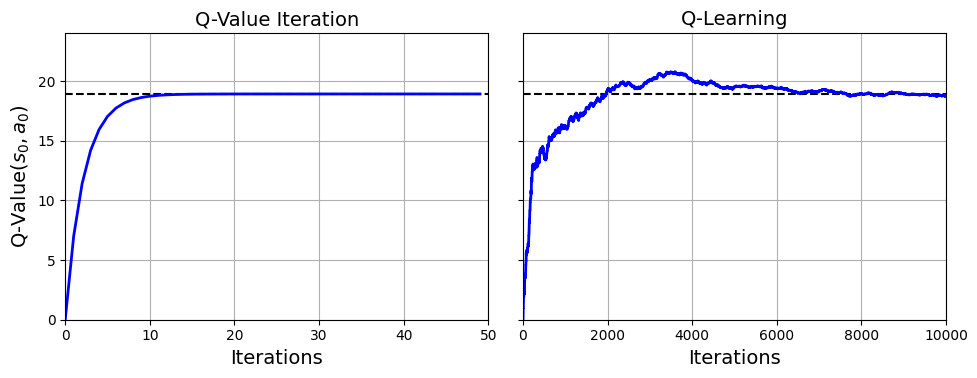

In [ ]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()